<a href="https://colab.research.google.com/github/alexanderpegoto/DS1007_FinalProject/blob/main/lab3_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT

Today we are going to walk through a few ways to study and modify BERT representations. Specifically, we will talk about probing BERT for knowledge and representation engineering.

In [ ]:
!pip install datasets
!pip install conllu

### 1.1 Probing BERT

One method of studying the representations of pretrained models is through a method known as *probing*. What this usually means in practice is training a classifier on the frozen hidden states of a pretrained model. The high level intuition is that if the hidden state encodes information relevant to some task, we should be able to use a simple model to solve the task using the hidden state.

We will explore this by probing for knowledge of part-of-speech.

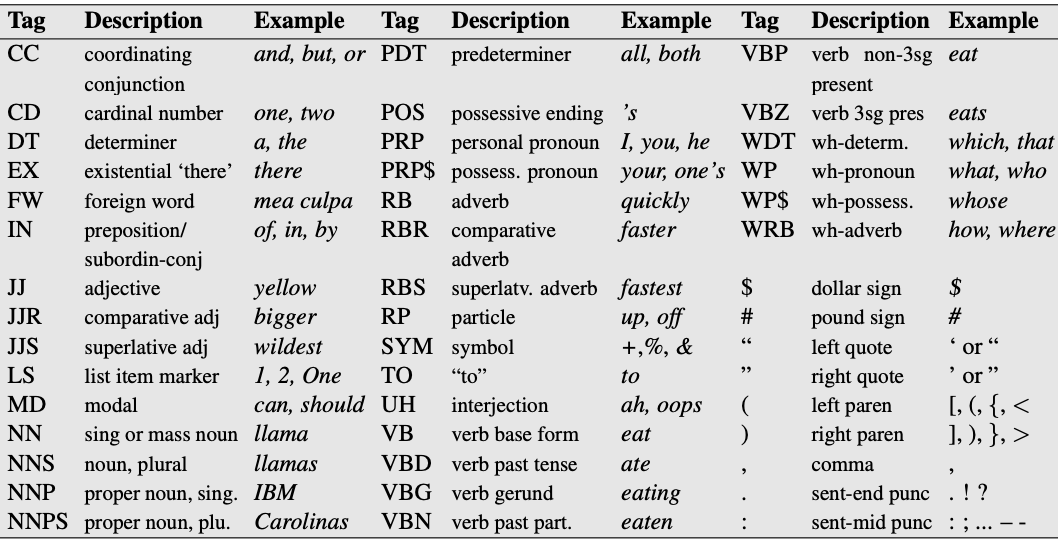

(Table from [Speech and Language Processing, ch.8](https://web.stanford.edu/~jurafsky/slp3/old_oct19/8.pdf) )


**For more, see the following papers (and others):**

A Structural Probe for Finding Syntax in Word Representations
https://aclanthology.org/N19-1419/

Conditional probing: measuring usable information beyond a baseline
https://aclanthology.org/2021.emnlp-main.122/

Information-Theoretic Probing for Linguistic Structure
https://aclanthology.org/N19-1419/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
import matplotlib.pyplot as plt

After handling our imports, we can load our Universal Dependencies dataset, which we will use for our classification task.

In [ ]:
# Load Universal Dependencies English EWT dataset and select small subsets
ud = load_dataset("universal_dependencies", "en_ewt")
train_ds = ud["train"].select(range(1000))
val_ds = ud["validation"].select(range(200))


In [ ]:
print(f"The text is {train_ds[0]['text']}")
print(f"The tags are {train_ds[0]['xpos']}")
print(f"The ids are {train_ds[0]['upos']}")

The text is Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
The tags are ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']
The ids are [10, 1, 10, 1, 6, 0, 16, 10, 10, 10, 1, 10, 1, 8, 0, 2, 8, 0, 2, 8, 0, 2, 10, 1, 2, 8, 6, 0, 1]


In [ ]:
# Build label mapping for UPOS tags
label_set = set(tag for sample in train_ds for tag in sample["upos"])
label_list = sorted(label_set)
label2id = {l: i for i, l in enumerate(label_list)}
num_labels = len(label_list)
print(label2id)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17}


Loading our BERT model and tokenizer

In [ ]:
# Load pretrained BERT and freeze its weights
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
bert = BertModel.from_pretrained(model_name).to("cuda")


In [ ]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
tokenizer.vocab

{'agencies': 6736,
 'chang': 11132,
 'tasting': 18767,
 'enzo': 26218,
 'kepler': 28219,
 '##2': 2475,
 '##wil': 29602,
 '10': 2184,
 'appearance': 3311,
 'slumped': 14319,
 '##ump': 24237,
 'flicker': 17909,
 'д': 1184,
 'goodwill': 22875,
 'hari': 21291,
 'cold': 3147,
 '##pate': 17585,
 'know': 2113,
 'transmit': 19818,
 'ten': 2702,
 'madison': 7063,
 '##mini': 25300,
 'apprentice': 13357,
 '##sion': 10992,
 'luxurious': 20783,
 'somehow': 5064,
 '##phon': 20846,
 'origin': 4761,
 '##genase': 28835,
 'germanic': 15139,
 'pas': 14674,
 'unsure': 12422,
 'р': 1195,
 'describing': 7851,
 '##liest': 21292,
 'stray': 15926,
 'colin': 6972,
 'angle': 6466,
 'applying': 11243,
 'considerably': 9839,
 'shattered': 10909,
 '[unused545]': 550,
 'corona': 21887,
 'hermann': 12224,
 'buck': 10131,
 'manifold': 19726,
 'ₚ': 1569,
 '##ug': 15916,
 'nowadays': 13367,
 'francoise': 28979,
 'likeness': 28275,
 'the': 1996,
 'patiently': 19080,
 'plurality': 29018,
 'bass': 3321,
 '##ron': 4948,
 '#

**Question:** What do you think ## indicates when when included in the token label?

Next, we will define our Linear Probe, which is just a linear layer that projects our hidden size to the number of classes we have for prediction.

In [ ]:
# Define a token-level linear probe
class TokenLinearProbe(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super().__init__()
        self.linear = nn.Linear(hidden_size, num_labels)
    def forward(self, hidden_states):
        return self.linear(hidden_states)


In [ ]:
# freeze our parameters
for param in bert.parameters():
    param.requires_grad = False


In [ ]:
probe = TokenLinearProbe(bert.config.hidden_size, num_labels).to("cuda")
optimizer = optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=-100)


In [ ]:
# Function to align POS labels with subword tokens (only first subword gets label)
def align_labels(batch_tokens, batch_upos, encodings):
    labels = []
    for i in range(len(batch_tokens)):
        word_ids = encodings.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[batch_upos[i][word_idx]])
                previous_word_idx = word_idx
            else:
                label_ids.append(-100)
        labels.append(label_ids)
    return torch.tensor(labels)



Now, for each layer we train a separate classifier for 10 epochs and get our best validation accuracy. Once computed, we can visualize how the accuracy changes across each layer.

In [ ]:
num_layers = bert.config.num_hidden_layers + 1  # include embedding layer
results = []


# Training loop

batch_size = 16
epochs = 10
for layer in range(num_layers):
    print(f"\nTraining probe on hidden layer {layer}")
    probe = TokenLinearProbe(bert.config.hidden_size, num_labels).to("cuda")
    optimizer = optim.Adam(probe.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    best_acc = 0
    for epoch in range(epochs):
        probe.train()
        for i in range(0, len(train_ds), batch_size):
            batch = train_ds[i: i + batch_size]
            encodings = tokenizer(batch["tokens"], is_split_into_words=True,
                                  padding=True, truncation=True, return_tensors="pt").to("cuda")
            labels = align_labels(batch["tokens"], batch["upos"], encodings).to("cuda")
            with torch.no_grad():
                outputs = bert(input_ids=encodings["input_ids"],
                              attention_mask=encodings["attention_mask"],
                               output_hidden_states=True)
                hidden_states = outputs.hidden_states[layer]
            logits = probe(hidden_states)
            loss = criterion(logits.view(-1, num_labels), labels.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} loss: {loss.item()}")

        probe.eval()
        correct, total = 0, 0
        for i in range(0, len(val_ds), batch_size):
            batch = val_ds[i: i + batch_size]
            encodings = tokenizer(batch["tokens"], is_split_into_words=True,
                                  padding=True, truncation=True, return_tensors="pt").to("cuda")
            labels = align_labels(batch["tokens"], batch["upos"], encodings).to("cuda")
            with torch.no_grad():
                outputs = bert(input_ids=encodings["input_ids"],
                              attention_mask=encodings["attention_mask"],
                              output_hidden_states=True)
                hidden_states = outputs.hidden_states[layer]
                logits = probe(hidden_states)
                preds = logits.argmax(dim=-1)
            for j in range(labels.shape[0]):
                for k in range(labels.shape[1]):
                    if labels[j, k] != -100:
                        total += 1
                        if preds[j, k].item() == labels[j, k].item():
                            correct += 1
        print(f"Epoch {epoch} Validation token-level accuracy:", correct / total)
        if correct/total > best_acc:
          best_acc = correct / total

    results.append(best_acc)



Training probe on hidden layer 0
Epoch 0 loss: 0.7012190222740173
Epoch 0 Validation token-level accuracy: 0.8190546528803545
Epoch 1 loss: 0.473608136177063
Epoch 1 Validation token-level accuracy: 0.8485967503692762
Epoch 2 loss: 0.3916582465171814
Epoch 2 Validation token-level accuracy: 0.8574593796159528
Epoch 3 loss: 0.34673115611076355
Epoch 3 Validation token-level accuracy: 0.8591826686361398
Epoch 4 loss: 0.3180910050868988
Epoch 4 Validation token-level accuracy: 0.8606597735105859
Epoch 5 loss: 0.29775509238243103
Epoch 5 Validation token-level accuracy: 0.8609059576563269
Epoch 6 loss: 0.28264695405960083
Epoch 6 Validation token-level accuracy: 0.8611521418020679
Epoch 7 loss: 0.2710358202457428
Epoch 7 Validation token-level accuracy: 0.8594288527818809
Epoch 8 loss: 0.26184743642807007
Epoch 8 Validation token-level accuracy: 0.8606597735105859
Epoch 9 loss: 0.25442230701446533
Epoch 9 Validation token-level accuracy: 0.8599212210733629

Training probe on hidden layer 

Text(0, 0.5, 'Accuracy')

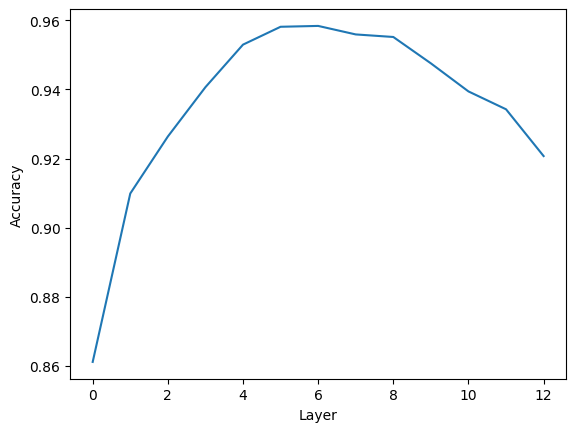

In [ ]:
plt.plot(results)
plt.xlabel("Layer")
plt.ylabel("Accuracy")

**Question:** Why might encoded information about POS differ across layers?

### 1.2 Activation Patching

Now, let's try a simple form of representation engineering. Here, we will swap the activations between a source and target sentence. This is to demonstrate the use of a tool called a **forward hook**. A forward hook allows you to run a function during each forward pass, which you can use for diagnostics (e.g. by storing activations or recording activation statistics) or representation engineering (by modifying activations). In this case, we will just swap the activations of an intermediate layer to change the predictions of a fine-tuned classifier.

In [ ]:
from transformers import BertForSequenceClassification

# Load a fine-tuned BERT model (SST-2) and its tokenizer.
model_name = "textattack/bert-base-uncased-SST-2"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Two inputs: source (whose activation we'll capture) and target.
source_text = "I absolutely loved the movie."
target_text = "The film was utterly disappointing."

source_inputs = tokenizer(source_text, return_tensors="pt")
target_inputs = tokenizer(target_text, return_tensors="pt")

In [ ]:
# Capture activation from layer 6's output.
stored_activation = {}

def save_activation(module, input, output):
    stored_activation["layer6"] = output.detach()

handle = model.bert.encoder.layer[6].output.register_forward_hook(save_activation)

# Run source input to store activation.
with torch.no_grad():
    _ = model(**source_inputs)

print(stored_activation["layer6"])

handle.remove()  # Remove the saving hook.

tensor([[[ 3.2519e-01, -5.3180e-01, -7.6118e-01,  ...,  2.0655e-01,
           1.8586e-01,  2.2975e-01],
         [-9.4710e-02,  8.2679e-01, -6.2379e-01,  ..., -1.8061e-01,
           5.8462e-01, -1.8598e-01],
         [ 1.5514e+00,  5.7784e-01,  9.4075e-01,  ...,  2.8715e-01,
           6.1919e-01, -3.6133e-01],
         ...,
         [ 1.0158e+00,  3.7885e-01, -1.0997e+00,  ...,  1.4060e+00,
           4.5243e-02, -1.2731e+00],
         [-1.3408e-01,  4.8391e-02, -1.0566e+00,  ..., -2.4521e-01,
           2.4855e-01,  6.0245e-01],
         [ 9.6430e-03, -1.7330e-02, -3.7127e-02,  ..., -9.4747e-04,
           4.6207e-03, -4.5977e-02]]])


In [ ]:
# Run target input normally.
with torch.no_grad():
    original_output = model(**target_inputs)

# Monkey-patch layer 6's output to replace its activation with the stored source activation.
layer6_output = model.bert.encoder.layer[6].output
original_forward = layer6_output.forward

def patched_forward(*args, **kwargs):
    # Compute but ignore the computed output; return stored activation instead.
    _ = original_forward(*args, **kwargs)
    return stored_activation["layer6"]

layer6_output.forward = patched_forward

# Run target input with patched activation.
with torch.no_grad():
    patched_output = model(**target_inputs)

# Revert the patch.
layer6_output.forward = original_forward

# Compare logits.
print("Original target logits:", original_output.logits)
print("Patched target logits:", patched_output.logits)


Original target logits: tensor([[ 3.7214, -3.3485]])
Patched target logits: tensor([[-3.7684,  3.7066]])


As you can see, the classifier's prediction has flipped based on the change in output logits.



### 1.3 Control Vectors

One final thing we will discuss briefly is the use of **control vectors**, which allow you to steer pretrained language models without fine-tuning. In general, you see this more often with autoregressive models, but the process is similar regardless. Here, we will try and change our masked prediction from positive to negative sentiment.

This is loosely inspired by this [blogpost](https://vgel.me/posts/representation-engineering/)

In [ ]:
import numpy as np
from transformers import BertForMaskedLM
from sklearn.decomposition import PCA

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(
    model_name,
    output_hidden_states=True
)
model.eval()
model.to("cuda")

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

One simple way to do this is by first creating a small set of contrasting examples. We will then try and find a direction in the representation space which captures the variation between these examples.

In [ ]:
contrast_pairs = [
    ("I love this product.", "I hate this product."),
    ("The food was delicious.", "The food was awful."),
    ("What a wonderful day!", "What a terrible day!"),
]



Next, we will extract the hidden states from each layer for these pairs and take their difference.

In [ ]:
def get_mean_hidden_states(sentence):
    """
    Given a sentence, tokenizes it and returns a list of hidden state vectors (one per layer)
    corresponding to the mean of all token representations in that layer.

    The output is a list where index 0 is the mean of the embedding layer outputs,
    and indices 1..N are the means of each transformer layer's outputs.
    """
    inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of (num_layers + 1) tensors; each shape: (1, seq_length, hidden_size)
    # For each layer, take the mean across the sequence (dimension 1)
    mean_reps = [hs.mean(dim=1)[0].cpu().numpy() for hs in hidden_states]
    return mean_reps

# For each contrasting pair, compute the difference (positive minus negative) for each layer.
num_layers = len(get_mean_hidden_states(contrast_pairs[0][0]))  # includes the embedding layer as index 0
diffs_by_layer = {layer: [] for layer in range(num_layers)}

for pos_sent, neg_sent in contrast_pairs:
    pos_hidden = get_mean_hidden_states(pos_sent)
    neg_hidden = get_mean_hidden_states(neg_sent)
    for layer in range(num_layers):
        diff = pos_hidden[layer] - neg_hidden[layer]
        diffs_by_layer[layer].append(diff)



**Question:** What is one method we can use to get a vector such that its direction explains the *variance* between these contrasting examples?

In [ ]:
control_vectors = {}
for layer in range(num_layers):
    diffs = np.stack(diffs_by_layer[layer], axis=0)  # shape: (num_pairs, hidden_size)
    pca = PCA(n_components=1)
    pca.fit(diffs)
    # The first principal component is taken as the control vector.
    cv = pca.components_[0]
    cv = cv / np.linalg.norm(cv)  # Normalize the vector
    control_vectors[layer] = cv

print("Control vectors computed for each layer (layer 0 = embeddings, layers 1..{} = transformer layers).".format(num_layers - 1))



Control vectors computed for each layer (layer 0 = embeddings, layers 1..12 = transformer layers).


In [ ]:
# Use a test sentence with [MASK] tokens.
test_sentence = "That was such a [MASK] experience"
inputs = tokenizer(test_sentence, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# First, get the original predictions.
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits  # shape: (1, seq_len, vocab_size)

Now, we apply the control vectors

In [ ]:
control_strength = 4

with torch.no_grad():
    input_ids = inputs['input_ids']            # shape: (1, seq_len)
    attention_mask = inputs['attention_mask']    # shape: (1, seq_len)
    # Prepare the extended attention mask as BERT does internally.
    extended_attention_mask = model.bert.get_extended_attention_mask(attention_mask, input_ids.shape, device)

    # 1. Start with the input embeddings.
    hidden_state = model.bert.embeddings(input_ids)  # shape: (1, seq_len, hidden_size)
    # Apply the control vector computed for the embedding layer (layer 0) to ALL tokens.
    cv_embed = torch.tensor(control_vectors[0], device=device, dtype=hidden_state.dtype)
    hidden_state = hidden_state - control_strength *  cv_embed.unsqueeze(0).unsqueeze(0)  # unsqueeze to broadcast over (batch, seq_len)

    # 2. Pass through each transformer layer, injecting the corresponding control vector after each layer.
    for i, layer_module in enumerate(model.bert.encoder.layer):
        layer_outputs = layer_module(hidden_state, attention_mask=extended_attention_mask)
        hidden_state = layer_outputs[0]  # new hidden state from this layer
        # The control vector for the transformer layer (layer i+1)
        cv_layer = torch.tensor(control_vectors[i+1], device=device, dtype=hidden_state.dtype)
        hidden_state = hidden_state - control_strength * cv_layer.unsqueeze(0).unsqueeze(0)

    # 3. Use the modified hidden state with the MLM head.
    modified_logits = model.cls(hidden_state)

# Identify the positions of the [MASK] tokens
mask_token_id = tokenizer.mask_token_id
mask_positions = (inputs['input_ids'] == mask_token_id).nonzero(as_tuple=False)
print("\n--- Original Predictions ---")
for pos in mask_positions:
    token_logits = logits[pos[0], pos[1], :]
    top_ids = torch.topk(token_logits, k=5).indices.cpu().tolist()
    top_tokens = [tokenizer.decode([tid]).strip() for tid in top_ids]
    print(f"Mask at position {pos[1].item()}: {top_tokens}")



print("\n--- Modified Predictions (after applying control vectors to all tokens) ---")
for pos in mask_positions:
    token_logits = modified_logits[0, pos[1], :]
    top_ids = torch.topk(token_logits, k=5).indices.cpu().tolist()
    top_tokens = [tokenizer.decode([tid]).strip() for tid in top_ids]
    print(f"Mask at position {pos[1].item()}: {top_tokens}")



--- Original Predictions ---
Mask at position 5: ['wonderful', 'good', 'strange', 'beautiful', 'great']

--- Modified Predictions (after applying control vectors to all tokens) ---
Mask at position 5: ['good', 'terrifying', 'terrible', 'frightening', 'strange']


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
